In [1]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd

****Heterologous expression of 5-HTP and MH4 pathway in Bacillus subtilis****

In [2]:
model = read_sbml_model('data/iYO844.xml')

In [3]:
model

Name,iYO844
Memory address,0x07fa384c90160
Number of metabolites,990
Number of reactions,1250
Number of groups,0
Objective expression,1.0*BIOMASS_BS_10 - 1.0*BIOMASS_BS_10_reverse_8788b
Compartments,"cytosol, extracellular space"


**Looking up metabolites involved in MH4 and 5-HTP synthesis**

In [4]:
for metabolite in model.metabolites.query('Formate', 'name'):
    print(metabolite.name, metabolite.id)

Formate for_c
Formate for_e


In [5]:
for metabolite in model.metabolites.query('GTP', 'name'):
    print(metabolite.name, metabolite.id)

DGTP C10H12N5O13P3 dgtp_c
GTP C10H12N5O14P3 gtp_c


In [6]:
for metabolite in model.metabolites.query('H2O', 'name'):
    print(metabolite.name, metabolite.id)

H2O H2O h2o_c
H2O H2O h2o_e
Oxaloglycolate C4H2O6 oxglyc_c
Sulfoacetate C2H2O5S sula_c
Sulfoacetate C2H2O5S sula_e


In [7]:
for metabolite in model.metabolites.query('Inorganic triphosphate', 'name'):
    print(metabolite.name, metabolite.id, metabolite.formula)

Inorganic triphosphate pppi_c HO10P3


In [8]:
for metabolite in model.metabolites.query('Nicotinamide', 'name'):
    print(metabolite.name, metabolite.id)

Nicotinamide adenine dinucleotide nad_c
Nicotinamide adenine dinucleotide - reduced nadh_c
Nicotinamide adenine dinucleotide phosphate nadp_c
Nicotinamide adenine dinucleotide phosphate - reduced nadph_c
Nicotinamide ncam_c


In [9]:
model.metabolites.h_c 

Metabolite identifier,h_c
Name,H+
Memory address,0x07fa36cd4ffa0
Formula,H
Compartment,c
In 616 reaction(s),"CDPMEK, DRIBabc, ASP1DC, AIRC1, ALCD2y, ADADir, CD2abc1, TECA4S_BS, CYSabc, GLYt2r, NTRIR2x, DDGLCNt2r, CITt2r, MTHFR3, ADEt2, ARABRr, GLUDxi, HXANt2r, TEICH45, HACD5, GALT, 3UMPt6, TMN, ALDD13,..."


In [10]:
for metabolite in model.metabolites.query('pterin', 'name'):
    print(metabolite.name, metabolite.id, metabolite.formula)

6-Pyruvoyl-5,6,7,8-tetrahydropterin 6pthp_c C9H11N5O3
Dihydroneopterin dhnpt_c C9H13N5O4


In [11]:
for metabolite in model.metabolites.query('Tryptophan', 'name'):
    print(metabolite.name, metabolite.id)

L-Tryptophan trp__L_c
L-Tryptophan trp__L_e


In [12]:
for metabolite in model.metabolites.query('O2 O2', 'name'):
    print(metabolite.name, metabolite.id)

O2 O2 o2_c
O2 O2 o2_e


**Creating missing metabolites**

In [13]:
MH2_3P = Metabolite(id='MH2_3P', compartment='c')

In [14]:
preMH2_3P = Metabolite(id='preMH2_3P', compartment='c')

In [15]:
MH2 = Metabolite(id='MH2', compartment='c')

In [16]:
MH4 = Metabolite(id='MH4', compartment='c')

In [17]:
HydroxyMH4 = Metabolite(id='hydroxy_MH4', compartment='c')

In [18]:
hydroxy_trp = Metabolite(id='hydroxy_trp', compartment='c')

**Creating and adding metabolites to the missing reactions as outlined in Table ..**

In [19]:
folE = Reaction('R05048')
folE.add_metabolites({model.metabolites.h2o_c: -1,
                      model.metabolites.gtp_c: -1,
                      model.metabolites.for_c: 1,
                      preMH2_3P: 1
                     })
print(folE.build_reaction_string())

gtp_c + h2o_c --> for_c + preMH2_3P


In [20]:
folX = Reaction('R11082')
folX.add_metabolites({preMH2_3P: -1,
                      MH2_3P: 1
                     })
print(folX.build_reaction_string())

preMH2_3P --> MH2_3P


In [21]:
MH2_3P_dephosphorylation = Reaction ('Putative_dephosphorylation')
MH2_3P_dephosphorylation.add_metabolites({MH2_3P: -1,
                                          MH2: 1,
                                          model.metabolites.pppi_c: 1
                                         })
print(MH2_3P_dephosphorylation.build_reaction_string())

MH2_3P --> MH2 + pppi_c


In [22]:
folM = Reaction('R11019')
folM.add_metabolites ({model.metabolites.nadph_c: -1,
                       model.metabolites.h_c: -1,
                       MH2: -1,
                       MH4: 1,
                       model.metabolites.nadp_c: 1
                      })
print(folM.build_reaction_string())

MH2 + h_c + nadph_c --> MH4 + nadp_c


In [23]:
phhB = Reaction ('R04734')
phhB.add_metabolites({HydroxyMH4: -1,
                      MH2: 1,
                      model.metabolites.h2o_c: 1
                     })
print(phhB.build_reaction_string())

hydroxy_MH4 --> MH2 + h2o_c


In [24]:
phhA = Reaction ('R12540')
phhA.add_metabolites({model.metabolites.trp__L_c: -1,
                      model.metabolites.o2_c: -1,
                      MH4: -1,
                      HydroxyMH4: 1,
                      hydroxy_trp: 1
                     })
print(phhA.build_reaction_string())

MH4 + o2_c + trp__L_c --> hydroxy_MH4 + hydroxy_trp


**Adding reactions to the model**

In [25]:
model.add_reactions([folE])

In [26]:
model.add_reactions([folX])

In [27]:
model.add_reactions([MH2_3P_dephosphorylation])

In [28]:
model.add_reactions([folM])

In [29]:
model.add_reactions([phhB])

In [30]:
model.add_reactions([phhA])

In [31]:
model.add_boundary(model.metabolites.hydroxy_trp, type='demand')

Reaction identifier,DM_hydroxy_trp
Name,demand
Memory address,0x07fa36610dc70
Stoichiometry,hydroxy_trp --> -->
GPR,
Lower bound,0
Upper bound,1000.0


In [32]:
model.reactions.DM_hydroxy_trp

Reaction identifier,DM_hydroxy_trp
Name,demand
Memory address,0x07fa36610dc70
Stoichiometry,hydroxy_trp --> -->
GPR,
Lower bound,0
Upper bound,1000.0


**Looking at max growth rate of an optimised model**

In [33]:
print(model.objective)

Maximize
1.0*BIOMASS_BS_10 - 1.0*BIOMASS_BS_10_reverse_8788b


In [34]:
model.optimize().objective_value

0.11796638932240017

**Checking max 5-HTP production and respective growth rate if objective value is changed to the 5-HTP export reaction**

In [35]:
with model:
    print(model.reactions.DM_hydroxy_trp)
    model.objective = model.reactions.DM_hydroxy_trp
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print(max_5HTP_production)
    print(solution.fluxes.BIOMASS_BS_10)

DM_hydroxy_trp: hydroxy_trp --> 
0.577614520311147
0.0


**Observing how the growth rate changes with increasing 5-HTP export flux**

In [36]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [37]:
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.DM_hydroxy_trp],
                    objective=model.reactions.BIOMASS_BS_10)

In [38]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,DM_hydroxy_trp
0,EX_glc__D_e,0.0,0.0,NaN,0.117966,1.255696e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.111820,1.190272e+01,NaN,0.030401
2,EX_glc__D_e,0.0,0.0,NaN,0.105674,1.124848e+01,NaN,0.060802
3,EX_glc__D_e,0.0,0.0,NaN,0.099528,1.059423e+01,NaN,0.091202
4,EX_glc__D_e,0.0,0.0,NaN,0.093381,9.939991e+00,NaN,0.121603
5,EX_glc__D_e,0.0,0.0,NaN,0.087235,9.285750e+00,NaN,0.152004
6,EX_glc__D_e,0.0,0.0,NaN,0.081089,8.631508e+00,NaN,0.182405
7,EX_glc__D_e,0.0,0.0,NaN,0.074942,7.977266e+00,NaN,0.212805
8,EX_glc__D_e,0.0,0.0,NaN,0.068796,7.323024e+00,NaN,0.243206
9,EX_glc__D_e,0.0,0.0,NaN,0.062650,6.668782e+00,NaN,0.273607


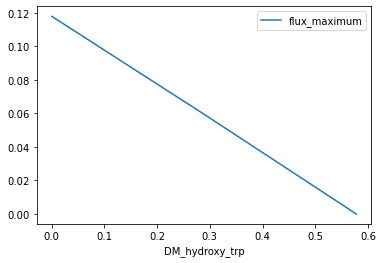

In [39]:
ppp_5HTP.plot(x='DM_hydroxy_trp', y='flux_maximum')

Not so good at all - we cannot get high flux towards 5-HTP without sacrificing the growth rate

In [40]:
from cobra.flux_analysis import flux_variability_analysis

In [41]:
hydroxy_trp_flux_analysis = flux_variability_analysis(model, model.reactions.DM_hydroxy_trp, fraction_of_optimum = 0.5)
print(hydroxy_trp_flux_analysis)

                minimum   maximum
DM_hydroxy_trp      0.0  0.291588


If we keep the growth rate at 50% of the maximum, we still can get around 52% of the max 5-HTP flux.

**Knocking out a single gene and setting the objective value of the model for 5-HTP export flux**

Only non-zero biomass production flux knock-outs are selected

In [42]:
for gene in model.genes:
    with model:
        gene.knock_out()
        model.objective = model.reactions.DM_hydroxy_trp
        solution = model.optimize()
        if solution.fluxes.BIOMASS_BS_10 > 0:
            print ('5-HTP export flux:', solution.fluxes.DM_hydroxy_trp, 'Gene ID:', gene.id, 'Biomass production:', solution.fluxes.BIOMASS_BS_10)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


No solutions are displayed, as in case of every knock-out and subsequent optimisation for max 5-HTP export no growth is observed.

**Knocking out a single gene, running optimisation for max biomass production flux and observing 5-HTP export flux**

Only non-zero 5-HTP export flux knock-outs are selected

In [50]:
knock_out_list = pd.DataFrame(columns=['Gene ID', '5-HTP export flux', 'Biomass production flux'])
pd.options.display.float_format = '{:,.4f}'.format
for gene in model.genes:
    with model:
        gene.knock_out()
        solution = model.optimize()
        if solution.fluxes.DM_hydroxy_trp > 0:
            knock_out_list = knock_out_list.append({ 'Gene ID': gene.id, '5-HTP export flux': solution.fluxes.DM_hydroxy_trp, 'Biomass production flux': model.optimize().objective_value}, ignore_index=True)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In each and every case, either the growth rate or the 5-HTP export flux are very close to zero, so it can be concluded that no knock-outs would improve the 5-HTP flux

In [51]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(knock_out_list)

      Gene ID  5-HTP export flux  Biomass production flux
0    BSU00500 0.2572             -0.0000                 
1    BSU35740 0.3400             -0.0000                 
2    BSU22830 0.3400             0.0000                  
3    BSU00760 0.2329             -0.0000                 
4    BSU00740 0.3400             -0.0000                 
5    BSU37150 0.2572             -0.0000                 
6    BSU14190 0.3400             -0.0000                 
7    BSU01780 0.2572             -0.0000                 
8    BSU40420 0.2572             -0.0000                 
9    BSU36900 0.3400             -0.0000                 
10   BSU09540 0.3400             -0.0000                 
11   BSU13890 0.0000             0.1164                  
12   BSU06520 0.5525             0.0000                  
13   BSU06420 0.3400             -0.0000                 
14   BSU06430 0.3400             -0.0000                 
15   BSU23380 0.3400             0.0000                  
16   BSU32170 

<ipython-input-51-f4d78eb1eacc>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


**Changing the boundaries for chorismate conversion to prephenate**

The idea behind this part is to restrict and control the flow of chorismate, a precursor of L-tryptophane and 5-HTP, to other aromatic amino acid production. For this we are setting bounds for a CHORM reaction (chorismate --> prephenate), where we are changing the lower bound to be above 0, so that some chorismate is routed for other essential amino acids in the biomass reaction to ensure growth, and the higher bound ensures we are not depleting the precursor pool for 5-HTP. 

In [135]:
#here we do not change the bounds for chorismate conversion
with model:
    model.reactions.R12540.bounds = 0, 0.3 #setting the upper bound for the phhA to allow some growth while producing 5-HTP
    model.objective = model.reactions.R12540 #setting objective for 5-HTP production
    solution = model.optimize()
    print('Max 5-HTP:', solution.objective_value)
    print('Growth:', solution.fluxes.BIOMASS_BS_10)
    print('CHORM:', solution.fluxes.CHORM)

Max 5-HTP: 0.3
Growth: 0.05691786248638337
CHORM: 0.016321937000182755


In [133]:
#here we try to keep chorismate conversion in tight bounds to see the effect on the the 5-HTP and biomass production.
#Chorismate is a precursor for L-tryptohan and other aromatic amino acids used in the biomass equation.
with model:
    model.reactions.CHORM.bounds = 0.001, 0.01 #setting tighter bounds for conversion of chorismate to prephenate to make sure the cell still grows while producing 5-HTP
    model.reactions.R12540.bounds = 0, 0.3 #setting the upper bound for the phhA to allow some growth while producing 5-HTP
    model.objective = model.reactions.R12540 #setting objective for 5-HTP production
    solution = model.optimize()
    print('Max 5-HTP:', solution.objective_value)
    print('Growth:', solution.fluxes.BIOMASS_BS_10)
    print('CHORM:', solution.fluxes.CHORM)

Max 5-HTP: 0.3
Growth: 0.034872002315500854
CHORM: 0.01


Keeping chorismate-to-prephenate reaction in tight bounds does not positively affect growth when 5-HTP is selected as an objective value, however, it has a detrimental effect on growth if the lower bound is above 0.163